In [62]:
# hypothesis: 
    # defer on examples close to the boundary
    # learn that zooming out/zooming in is better for certain images and not others 
%load_ext autoreload
%autoreload 2
import sys
import torch
import numpy as np
np.random.seed(42)

import random
from tqdm.notebook import tqdm 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from PIL import Image
from new_tta_models import ImageW, ImageS, ImageWS, Original, StandardTTA

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as nn_f
import torch.nn as nn

sns.set_style('white')
sys.path.insert(0, '../')
from utils.dataloading_utils import MyIter, MyLoader
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms.functional as F
from utils.imagenet_utils import accuracy

from mnist_train import Net
from utils.gpu_utils import restrict_GPU_pytorch

restrict_GPU_pytorch('1')
def inverse_normalize(tensor, mean, std):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

class Scale(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size, pct_low=1, pct_high=1):
        assert isinstance(output_size, (int, tuple))
        self.pct_range = (pct_low, pct_high)
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, img, mode='tensor'):
        if mode == 'pil':
            img = inverse_normalize(img, (0.1307,), (0.3081,))
            img = transforms.ToPILImage()(img)
        h, w = img.size
        pct = random.uniform(self.pct_range[0], self.pct_range[1])
        new_h, new_w = int(pct*h), int(pct*w)
        if new_h < h:
            # when new_h < h, or your pct has gone down.. cr
            img = F.center_crop(img, (new_h, new_w))
            img = F.resize(img, self.output_size, Image.BILINEAR)
        else:
            # when new_h > h, pad until you reach new_h
            # resize to output size
            w_pad = int((new_w - w)/2)
            h_pad = int((new_h - h)/2)
            img = F.pad(img, (w_pad, h_pad))
            img = F.resize(img, self.output_size, Image.BILINEAR)
        if mode == 'pil':
            img = transforms.ToTensor()(img)

        return img
    
class Orig(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self):
        pass

    def __call__(self, img, mode='tensor'):
        return img
    
n_classes = 3
l_zi, u_zi = .7, 1.0
l_zo, u_zo = 1.0, 1.3
l_zzo, u_zzo = 1.3, 1.6
dataset = datasets.MNIST('../datasets', download=True, train=True, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))
# Make sure transform is not single scale (range of scales)
zi_dataset = datasets.MNIST('../datasets', download=True, train=True, transform=transforms.Compose([
                               Scale((28, 28), l_zi, u_zi),
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))
zi_dataset.targets[:] = 2

zo_dataset = datasets.MNIST('../datasets', download=True, train=True, transform=transforms.Compose([
                           Scale((28, 28), l_zo, u_zo),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))
zo_dataset.targets[:] = 1

zzo_dataset = datasets.MNIST('../datasets', download=True, train=True, transform=transforms.Compose([
                           Scale((28, 28), l_zzo, u_zzo),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))
zzo_dataset.targets[:] = 0

digit = 8
dataset_pct = .02
digit_idxs = np.where(dataset.targets == digit)[0]
digit_idxs = np.random.choice(digit_idxs, int(dataset_pct*len(digit_idxs)), replace=False)
concat_dataset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(zi_dataset, digit_idxs), 
                                                 torch.utils.data.Subset(zo_dataset, digit_idxs),
                                                 torch.utils.data.Subset(zzo_dataset, digit_idxs),])

batch_size = 128
train_dataloader = torch.utils.data.DataLoader(concat_dataset, 
                                         batch_size=batch_size,
                                         num_workers=0, shuffle=True)
print(len(concat_dataset))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using GPU:1
351


# Visualize dataset

In [63]:
x, y = next(iter(train_dataloader))

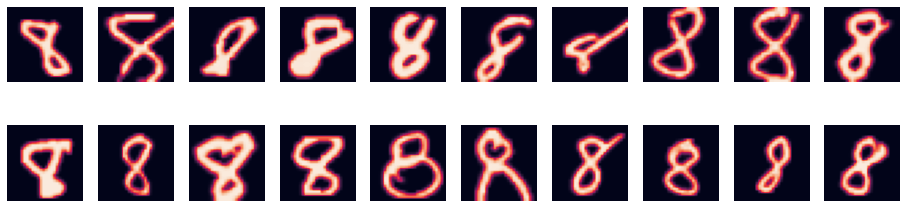

In [64]:
n_augs = 20
fig, axes = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 4))
label = 2
plt_idxs = np.where(y == label)[0]
plt_x = x[plt_idxs]
for i in range(n_augs):
    img = plt_x[i][0].cpu()
    ax = axes[int(i/10), i%10]
    ax.imshow(img)
    ax.axis('off')

# Train model

In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        #self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, n_classes)
        
        self.fc1 = nn.Linear(5408, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = nn_f.relu(x)
#         x = self.conv2(x)
#         x = nn_f.relu(x)
        x = nn_f.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = nn_f.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = nn_f.log_softmax(x, dim=1)
        return output
    
    def features(self, x):
        x = self.conv1(x)
        x = nn_f.relu(x)
#         x = self.conv2(x)
#         x = nn_f.relu(x)
        x = nn_f.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


In [66]:
device = torch.device("cuda")
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=.7)
tr_ls = []
tr_accs = []
epochs = 20
for epoch in tqdm(range(1, epochs + 1)):
    losses = []
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = nn_f.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(np.mean(losses))
    tr_ls.append(np.mean(losses))

1.9880973895390828
2.0281577706336975
0.667722761631012
0.5872073968251547
0.5171447296937307
0.4480980336666107
0.3817934493223826
0.341926505168279
0.5351504584153494
0.47891679406166077
0.3639500339825948
0.3557099997997284
0.2771248420079549
0.41621487339337665
0.39144744475682575
0.3335566023985545
0.24845662713050842
0.28292157252629596
0.4196375509103139
0.26809146006902057



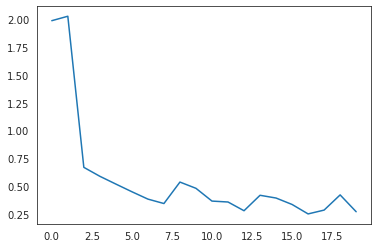

In [67]:
plt.plot(tr_ls)

In [68]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in train_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += nn_f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(train_dataloader.dataset)
correct /= len(train_dataloader.dataset)
print(test_loss, correct)

0.20074769913980425 0.9316239316239316


# Create test dataloaders

In [69]:
test_dataset = datasets.MNIST('../datasets', download=True, train=False, transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))
# Make sure transform is not single scale (range of scales)
test_zi_dataset = datasets.MNIST('../datasets', download=True, train=False, transform=transforms.Compose([
                               Scale((28, 28), l_zi, u_zi),
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))
test_zi_dataset.targets[:] = 2

test_zo_dataset = datasets.MNIST('../datasets', download=True, train=False, transform=transforms.Compose([
                           Scale((28, 28), l_zo, u_zo),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))
test_zo_dataset.targets[:] = 1

test_zzo_dataset = datasets.MNIST('../datasets', download=True, train=False, transform=transforms.Compose([
                           Scale((28, 28), l_zzo, u_zzo),
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,)),
                       ]))
test_zzo_dataset.targets[:] = 0

test_digit_idxs = np.where(test_dataset.targets == digit)[0]
test_concat_dataset = torch.utils.data.ConcatDataset([torch.utils.data.Subset(test_zi_dataset, test_digit_idxs), 
                                                     torch.utils.data.Subset(test_zo_dataset, test_digit_idxs),
                                                     torch.utils.data.Subset(test_zzo_dataset, test_digit_idxs)])

batch_size = 128
test_dataloader = torch.utils.data.DataLoader(test_concat_dataset, 
                                         batch_size=batch_size,
                                         num_workers=0, shuffle=True)

(array([974.,   0.,   0.,   0.,   0., 974.,   0.,   0.,   0., 974.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

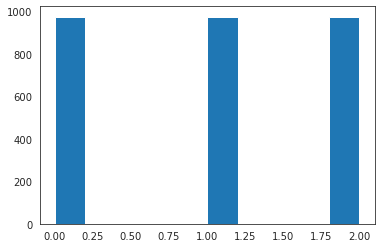

In [70]:
gg = [test_concat_dataset[i][1] for i in range(len(test_concat_dataset))]
plt.hist(gg)

# Original model accuracy

In [71]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += nn_f.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

test_loss /= len(test_dataloader.dataset)
correct /= len(test_dataloader.dataset)
print(test_loss, correct)

0.2164838524569721 0.9120465434633812


# Define test-time augmentation loaders

In [72]:
from torch.utils.data import Dataset
import pdb
class TTADataset(Dataset):
    def __init__(self, dataset, idxs, transform=None):
        self.dataset = dataset
        self.idxs = idxs
        self.transform = transform

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img, y = self.dataset[self.idxs[idx]]

        if self.transform:
            img = self.transform(img, 'pil')
        return img, y

def get_aug_transform(augmentation):
    # These could be compositions too
    output_size = (224, 224)
    output_size = (28, 28)
    aug_transform_map = {'orig': Orig(),
                         'scale_1.04': Scale(output_size, 1.04, 1.05),
                         'scale_1.30': Scale(output_size, 1.30, 1.31), 
                         'scale_1.20': Scale(output_size, 1.20, 1.21), 
                         'scale_1.10': Scale(output_size, 1.20, 1.21), 
                         'scale_0.70': Scale(output_size, 0.70, 0.71),
                         'scale_0.10': Scale(output_size, 0.10, 0.11),
                         'scale_1.15': Scale(output_size, 1.15, 1.16),
                         'scale_1.25': Scale(output_size, 1.25, 1.26),
                         'scale_0.85': Scale(output_size, 0.85, 0.86),
                         'scale_0.80': Scale(output_size, 0.80, 0.81),
                         'scale_0.90': Scale(output_size, 0.80, 0.81),
                         'scale_0.96': Scale(output_size, 0.96, 0.97),
                         'scale_0.60': Scale(output_size, 0.60, 0.61)}
    return aug_transform_map[augmentation]   


In [183]:
test_dataset = test_concat_dataset
# go from test_concat_dataset
# to test_tta_concat_dataset
augs = ['orig', 'scale_0.70', 'scale_0.80']
all_idxs = list(range(len(test_concat_dataset)))
np.random.shuffle(all_idxs)
val_idxs = all_idxs[:int(len(all_idxs)/2)]
test_idxs = all_idxs[:int(len(all_idxs)/2)]
batch_size = 1024
train_ds_list = [TTADataset(test_concat_dataset, val_idxs, get_aug_transform(aug)) for aug in augs]
train_dl_list =  [torch.utils.data.DataLoader(ds, batch_size=batch_size, 
                                           num_workers=0, shuffle=False) for ds in train_ds_list]
test_ds_list = [TTADataset(test_concat_dataset, test_idxs, get_aug_transform(aug)) for aug in augs]
test_dl_list = [torch.utils.data.DataLoader(ds, batch_size=batch_size, 
                                           num_workers=0, shuffle=False) for ds in test_ds_list]
train_dataloader, test_dataloader = MyLoader(train_dl_list), MyLoader(test_dl_list)

(array([490.,   0.,   0.,   0.,   0., 492.,   0.,   0.,   0., 479.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

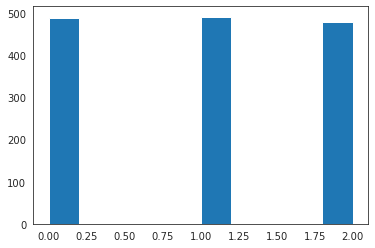

In [184]:
gg = [test_ds_list[0][i][1] for i in range(len(train_ds_list[0]))]
plt.hist(gg)

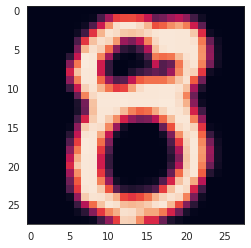

In [205]:
x, y = next(iter(test_dataloader))


(-0.5, 27.5, 27.5, -0.5)

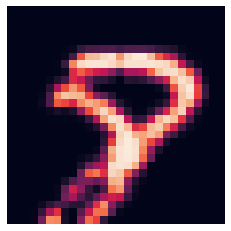

In [218]:
plt.imshow(x[0][2][0])
plt.axis('off')

# Standard test-time augmentation

In [185]:
results = []
stta_model = StandardTTA(model)
stta_model.cuda('cuda:0')
all_targets = []
all_outputs = []
for examples, target in tqdm(test_dataloader):
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = stta_model(examples)
    all_outputs.append(output)
    all_targets.append(target)
all_outputs = torch.cat(all_outputs, axis=0)
all_targets = torch.cat(all_targets, axis=0)
n_runs = 5
pct = .8
for i in range(n_runs):
    n_outputs = len(all_outputs)
    n_to_sample = int(pct * n_outputs)
    idxs = np.random.choice(range(n_outputs), size=n_to_sample, replace=False)
    sampled_outputs = all_outputs[idxs,:]
    sampled_targets = all_targets[idxs]
    acc1 = accuracy(sampled_outputs, sampled_targets, topk=(1,))[0]
    results.append({'method': 'Standard TTA', 'accuracy': acc1.item()})

# Original model (TTA implementation)

In [186]:
orig_model = Original(model, 0)
orig_model.cuda('cuda:0')
orig_model.eval()
all_outputs = []
all_targets = []
for examples, target in tqdm(test_dataloader):
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    output = orig_model(examples)
    all_outputs.append(output)
    all_targets.append(target)
all_outputs = torch.cat(all_outputs, axis=0)
all_targets = torch.cat(all_targets, axis=0)
for i in range(n_runs):
    n_outputs = len(all_outputs)
    n_to_sample = int(pct * n_outputs)
    idxs = np.random.choice(range(n_outputs), size=n_to_sample, replace=False)
    sampled_outputs = all_outputs[idxs,:]
    sampled_targets = all_targets[idxs]
    acc1 = accuracy(sampled_outputs, sampled_targets, topk=(1,))[0]
    results.append({'method': 'Original Model', 'accuracy': acc1.item()})

# Helper fs for our mdoels

In [187]:
def eval_agg_model(agg_model, dataloader):
    agg_model.eval()
    agg_model.cuda('cuda:0')
    model.cuda('cuda:0')
    test_acc1s = []
    outputs = []
    targets = []
    for examples, target in dataloader:
        examples = examples.cuda('cuda:0', non_blocking=True)
        target = target.cuda('cuda:0', non_blocking=True)    
        output = agg_model(examples)
        outputs.extend(output.cpu())
        targets.extend(target.cpu())
        acc1 = accuracy(output, target, topk=(1,))
        test_acc1s.append(acc1[0].item())
    return np.mean(test_acc1s), outputs, targets


def train_agg_model(model, dataloader, n_augs, agg_model_name, n_features, epochs=10):
    if agg_model_name == 'image_s':
        agg_model = ImageS(model, 0, 1, n_features)
    elif agg_model_name == 'image_w':
        agg_model = ImageW(model,n_augs, 0, 1, n_features)
    elif agg_model_name == 'image_ws':
        agg_model = ImageWS(model,n_augs, 0, 1, n_features)

    agg_model.cuda('cuda:0')
    criterion = torch.nn.CrossEntropyLoss()
    criterion.cuda('cuda:0')
    optimizer = torch.optim.SGD(agg_model.parameters(), lr=.01, momentum=.9, weight_decay=1e-4)

    losses = []
    acc1s = []
    for epoch in tqdm(range(epochs)):
        epoch_loss = []
        for examples, target in dataloader:
            examples = examples.cuda('cuda:0', non_blocking=True)
            target = target.cuda('cuda:0', non_blocking=True)
            output = agg_model(examples)
            loss = criterion(output, target)
            acc1  = accuracy(output, target, topk=(1,))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            acc1s.append(acc1[0].item())
        losses.append(np.mean(epoch_loss))
    return agg_model, losses, acc1s

# Learning S

In [188]:
n_augs = len(augs)
s_model, losses, acc1s  = train_agg_model(model, train_dataloader, n_augs, 'image_s', 128, 20)
acc1, s_outputs, s_targets= eval_agg_model(s_model, test_dataloader)
print(acc1)


91.54915618896484


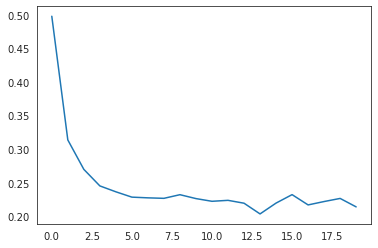

In [189]:
plt.plot(losses)

In [190]:
all_outputs = torch.stack(s_outputs)
all_targets = torch.Tensor(s_targets)
for i in range(n_runs):
    n_outputs = len(all_outputs)
    n_to_sample = int(pct * n_outputs)
    idxs = np.random.choice(range(n_outputs), size=n_to_sample, replace=False)
    sampled_outputs = all_outputs[idxs,:]
    sampled_targets = all_targets[idxs]
    acc1 = accuracy(sampled_outputs, sampled_targets, topk=(1,))[0]
    results.append({'method': 'S Model', 'accuracy': acc1.item()})

## Learning W

In [191]:
n_augs = len(augs)
w_model, losses, acc1s  = train_agg_model(model, train_dataloader, n_augs, 'image_w', 128, 20)
acc1, w_outputs, w_targets = eval_agg_model(s_model, test_dataloader)
print(acc1)


92.88718032836914


In [192]:
all_outputs = torch.stack(w_outputs)
all_targets = torch.Tensor(w_targets)
for i in range(n_runs):
    n_outputs = len(all_outputs)
    n_to_sample = int(pct * n_outputs)
    idxs = np.random.choice(range(n_outputs), size=n_to_sample, replace=False)
    sampled_outputs = all_outputs[idxs,:]
    sampled_targets = all_targets[idxs]
    acc1 = accuracy(sampled_outputs, sampled_targets, topk=(1,))[0]
    results.append({'method': 'W Model', 'accuracy': acc1.item()})

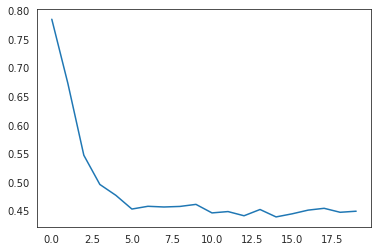

In [193]:
plt.plot(losses)

# Learning W and S

In [194]:
# n_augs = len(augs)
# ws_model, losses, acc1s  = train_agg_model(model, train_dataloader, n_augs, 'image_ws', 128, 50)
# acc1, ws_outputs, ws_targets = eval_agg_model(s_model, test_dataloader)
# print(acc1)

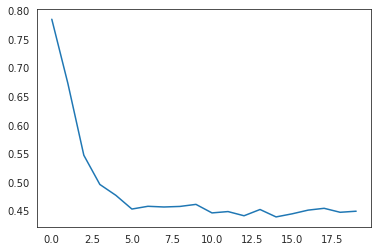

In [195]:
#plt.plot(losses)

# Plots comparing accuracies of models

Text(0.5, 0, 'Test-time augmentation method')

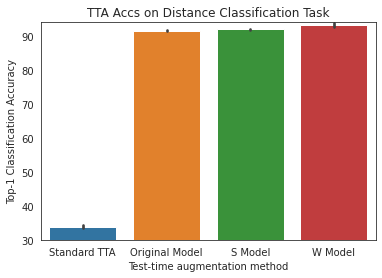

In [202]:
results_df = pd.DataFrame(results)
sns.barplot(x='method', y='accuracy', data=results_df)
plt.ylim(30, 94)
plt.title("TTA Accs on Distance Classification Task")
plt.ylabel("Top-1 Classification Accuracy")
plt.xlabel("Test-time augmentation method")
#results_df

In [140]:
results_df

,method,accuracy
0,Standard TTA,32.448631
1,Standard TTA,33.047947
2,Standard TTA,31.250000
3,Standard TTA,33.133564
4,Standard TTA,33.732876
5,Original Model,90.582191
6,Original Model,91.695206
7,Original Model,91.438354
8,Original Model,92.123291
9,Original Model,91.609589


# Plots

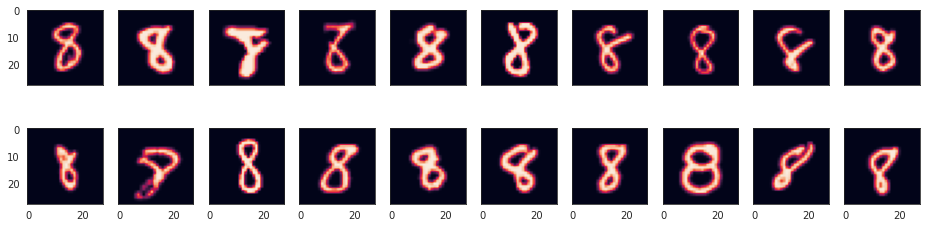

In [38]:
# First check to see if targets look different from each other 
x, y = next(iter(test_dataloader))
n_augs = 20
fig, axes = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 4))
label = 0
plt_idxs = np.where(y == label)[0]
plt_x = x[:,plt_idxs]
for i in range(n_augs):
    img = plt_x[0][i][0].cpu()
    ax = axes[int(i/10), i%10]
    ax.imshow(img)

In [148]:
# Distribution of learned s 
# Iterate through test_dataloader, get_s for each image, store that? 
s_model.eval()
s_vals = []
examples_list = []
for examples, target in tqdm(test_dataloader):
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    s = s_model.get_s(examples)
    s_vals.extend(s.cpu())
    examples_list.extend(examples.cpu())


In [149]:
s.shape

torch.Size([974, 1])

Text(0, 0.5, '# of Images')

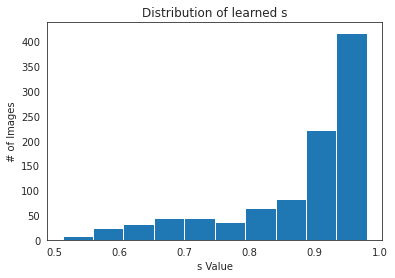

In [150]:
plt.hist([x.item() for x in s_vals])
plt.title("Distribution of learned s")
plt.xlabel("s Value")
plt.ylabel("# of Images")

In [151]:
# Examples of s = 1
# Example sof s = 0
# Examples of s = .5 
s_model.eval()
s_vals = []
examples_list = []
low_s_images, low_s_y = [], []
high_s_images, high_s_y = [], []
mid_s_images_0, mid_s_images_1 = [], []
for examples, target in tqdm(test_dataloader):
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    s = s_model.get_s(examples)
    for i, s_i in enumerate(s):
        if s_i < .1:
            low_s_images.append(examples[0][i])
            low_s_y.append(target[i].item())
        elif s_i > .4 and s_i < .6:
            if target[i].item() == 0:
                mid_s_images_0.append(examples[0][i])
            elif target[i].item() == 1:
                mid_s_images_1.append(examples[0][i])
        elif s_i > .9:
            high_s_images.append(examples[0][i])
            high_s_y.append(target[i].item())

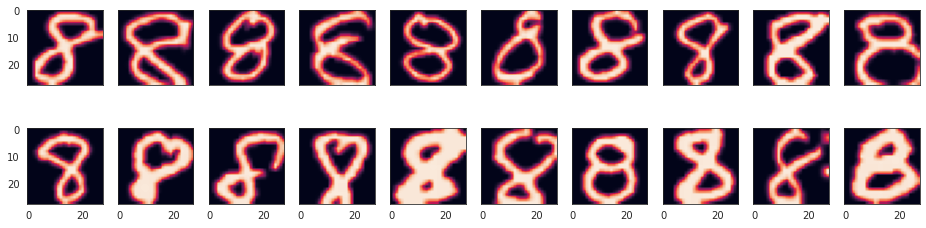

In [161]:
# First check to see if targets look different from each other 
n_imgs = 20
fig, axes = plt.subplots(2, 10, sharex=True, sharey=True, figsize=(16, 4))
for i in range(n_imgs):
    img = mid_s_images_1[i].cpu()[0]
    ax = axes[int(i/10), i%10]
    ax.imshow(img)

In [ ]:
plt.hist(low_s_y)

In [43]:
# Distribution of learned w 
ws_model.eval()
w_vals = []
s_vals = []
for examples, target in tqdm(test_dataloader):
    examples = examples.cuda('cuda:0', non_blocking=True)
    target = target.cuda('cuda:0', non_blocking=True)    
    s, w = ws_model.get_sw(examples)
    w_vals.extend(w.cpu())
    s_vals.extend(s.cpu())

NameError: name 'orig_image' is not defined

In [ ]:
gg = [x.cpu()[0].item() for x in w_vals] 

In [ ]:
w_vals